## Exercise 2: Dask DataFrames for Large Tabular Data

In [ ]:
# imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import pandas as pd
import dask.dataframe as dd

#### Code to generate tumor growth patient data as CSV:

In [2]:
# ----------- flex parameters -----------

# working directory
working_dir = "longitudinal_data"

init_size_min = 0.1
init_size_max = 1.2

# Growth rates per drug (cm per month)
growth_rates = {
    "Velocor": -0.002,   # very effective
    "Lunadrex": 0.003,
    "Zanthera": 0.028,
    "Placebo":  0.052    # least effective
}

# Experiment duration
start_date = datetime(2025, 1, 11)
n_months = 24

# tumor size variation
size_noise = 0.03

# ---------------------------------------

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# Create output directory
os.makedirs(working_dir, exist_ok=True)

# Random patient names
names = [
    "Liam", "Noah", "Oliver", "Elijah", "James", "William", "Benjamin", "Lucas", "Henry", "Alexander",
    "Mason", "Michael", "Ethan", "Daniel", "Jacob", "Logan", "Jackson", "Levi", "Sebastian", "Mateo",
    "Jack", "Owen", "Theodore", "Aiden", "Samuel", "Joseph", "John", "David", "Wyatt", "Matthew",
    "Luke", "Asher", "Carter", "Julian", "Grayson", "Isaac", "Lincoln", "Ezra", "Gabriel", "Anthony",
    "Jayden", "Dylan", "Leo", "Hudson", "Thomas", "Nolan", "Elias", "Charles", "Josiah", "Caleb",
    "Olivia", "Emma", "Charlotte", "Amelia", "Sophia", "Isabella", "Ava", "Mia", "Evelyn", "Luna",
    "Harper", "Camila", "Gianna", "Elizabeth", "Eleanor", "Ella", "Abigail", "Sofia", "Avery", "Scarlett",
    "Emily", "Aria", "Penelope", "Chloe", "Layla", "Mila", "Nora", "Hazel", "Lily", "Grace",
    "Aurora", "Riley", "Zoey", "Victoria", "Hannah", "Addison", "Lucy", "Eliana", "Isla", "Stella",
    "Quinn", "Peyton", "Jordan", "Sawyer", "Rowan", "Taylor", "Skyler", "Emerson", "Parker", "Morgan"
]

# Random drug names
drugs = list(growth_rates.keys())

# Assign each patient an ID, name, and drug
ids = random.sample(range(100, 2001), len(names))
patient_data = pd.DataFrame({
    "ID": ids,
    "Name": names,
    "Drug": [random.choice(drugs) for _ in names],
    "InitialDiameter": np.round(np.random.uniform(init_size_min, init_size_max, len(names)), 2)
})

for month in range(n_months):
    # Random jitter between -3 and +3 days
    jitter = timedelta(days=random.randint(-3, 3))
    date = start_date + timedelta(days=30 * month) + jitter
    date_str = date.strftime("%Y-%m-%d")

    rows = []
    for _, row in patient_data.iterrows():
        growth = growth_rates[row["Drug"]]
        tumor_size = row["InitialDiameter"] + growth * month
        tumor_size += np.random.normal(0, size_noise)  # small noise
        tumor_size = max(tumor_size, 0.01)  # clamp to realistic min

        rows.append({
            "Date": date_str,
            "ID": row["ID"],
            "Name": row["Name"],
            "TumorDiameter_cm": round(tumor_size, 3),
            "Drug": row["Drug"]
        })

    df_month = pd.DataFrame(rows)
    filename = os.path.join(working_dir, f"{date_str}.csv")
    df_month.to_csv(filename, index=False)

print(f"Generated {n_months} CSV files in '{working_dir}/'")


Generated 24 CSV files in 'longitudinal_data/'


#### Loading all data in folder in Dask DataFrame with *.csv Wildcard

In [3]:
df = dd.read_csv(os.path.join(working_dir, "*.csv"))

#### Visualizing Task Stream with Dask Client

In [ ]:
from dask.distributed import Client

client = Client(n_workers=8, threads_per_worker=2)

display(client)

C:\Users\conor\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52469 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52469/status,
Dashboard: http://127.0.0.1:52469/status,Workers: 8
Total threads: 16,Total memory: 31.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52473,Workers: 0
Dashboard: http://127.0.0.1:52469/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52512,Total threads: 2
Dashboard: http://127.0.0.1:52519/status,Memory: 3.95 GiB
Nanny: tcp://127.0.0.1:52476,


2025-08-05 21:03:26,729 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ebcb8c04937ac447cfc3c5d653541a3b initialized by task ('shuffle-transfer-ebcb8c04937ac447cfc3c5d653541a3b', 21) executed on worker tcp://127.0.0.1:52514
2025-08-05 21:03:27,314 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ebcb8c04937ac447cfc3c5d653541a3b deactivated due to stimulus 'task-finished-1754445807.3123193'


#### Testing various Pandas operations with Dask:

In [5]:
# mean
mean_task = df["TumorDiameter_cm"].mean()

print("Mean of all diameters:", mean_task.compute())

Mean of all diameters: 0.8255804166666667


In [6]:
# standard deviation
std_task = df["TumorDiameter_cm"].std()

print("Std. dev. of all diameters:", std_task.compute())

Std. dev. of all diameters: 0.437650548612648


In [7]:
# partition mapping
def give_last_name(df):

    df["Name"] += " Mc" + df["Name"] + "son"
    return df

name_task = df.map_partitions(give_last_name)

new_df = name_task.compute()

print(new_df)

          Date    ID                  Name  TumorDiameter_cm      Drug
0   2025-01-08  1409        Liam McLiamson             0.513  Lunadrex
1   2025-01-08   328        Noah McNoahson             1.141  Lunadrex
2   2025-01-08   151    Oliver McOliverson             0.913  Lunadrex
3   2025-01-08  1618    Elijah McElijahson             0.700   Placebo
4   2025-01-08   663      James McJamesson             0.263   Placebo
..         ...   ...                   ...               ...       ...
95  2026-11-29   646    Taylor McTaylorson             0.780  Lunadrex
96  2026-11-29  1537    Skyler McSkylerson             0.610   Velocor
97  2026-11-29  1499  Emerson McEmersonson             0.483   Velocor
98  2026-11-29  1427    Parker McParkerson             0.093   Velocor
99  2026-11-29   246    Morgan McMorganson             0.311  Lunadrex

[2400 rows x 5 columns]


#### Plot Tumor Groth with Time, with Error Bars

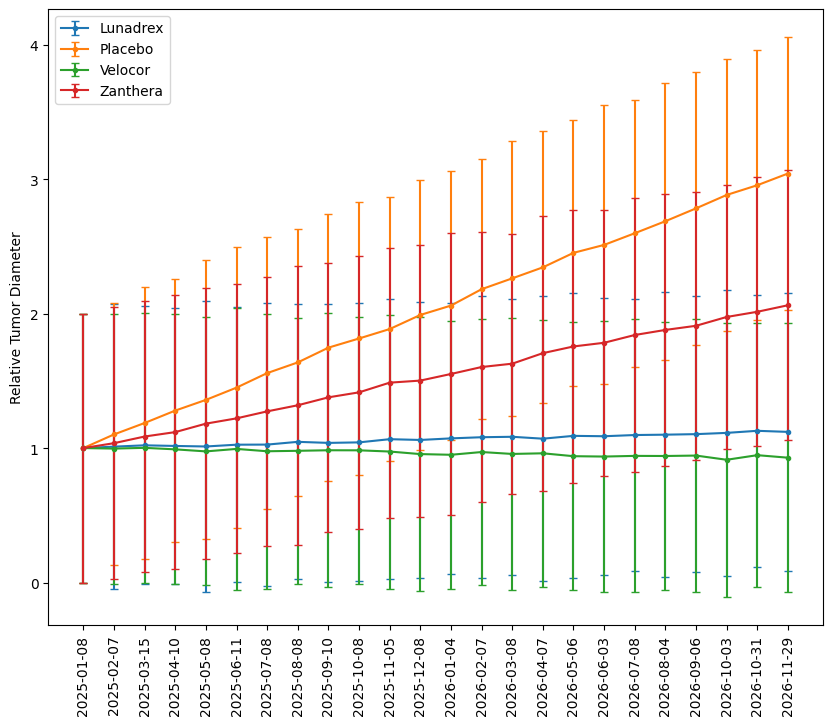

In [ ]:
# Compute both mean and std using Pandas Aggregation: Dask
agg_task = (
    df.groupby(["Date", "Drug"])["TumorDiameter_cm"]
    .agg(["mean", "std"])
    .reset_index()
)

# Trigger computation: Dask -> Pandas
agg_growth = agg_task.compute() # Run the tasks! Spit out Pandas

# Pivot for plotting: Pandas
means = agg_growth.pivot(index="Date", columns="Drug", values="mean")
stds  = agg_growth.pivot(index="Date", columns="Drug", values="std")

# Normalizing: Pandas
means = means / means.iloc[0]
stds = stds / stds.iloc[0]

# Plotting
_, ax = plt.subplots(figsize=(10, 8))

for drug in means.columns:
    ax.errorbar(
        means.index,
        means[drug],
        yerr=stds[drug],
        label=drug,
        fmt='.-',
        capsize=3,
    )

ax.set_ylabel("Relative Tumor Diameter")
ax.legend()
ax.tick_params(axis='x', labelrotation=90)

In [9]:
# Shut down distributed Client

client.shutdown()